In [1]:
library(refund)
data(DTI); attach(DTI)
names(DTI)

[1] "ID"         "visit"      "visit.time" "Nscans"     "case"      
[6] "sex"        "pasat"      "cca"        "rcst"

In [4]:
DTI.complete <- subset(DTI, complete.cases(DTI))
DTI.baseline <- subset(DTI.complete, visit == 1 & case == 1)
tract <- 1:93
n <- length(unique(DTI.baseline$ID)) 
dim(DTI.baseline$cca)

[1] 66 93

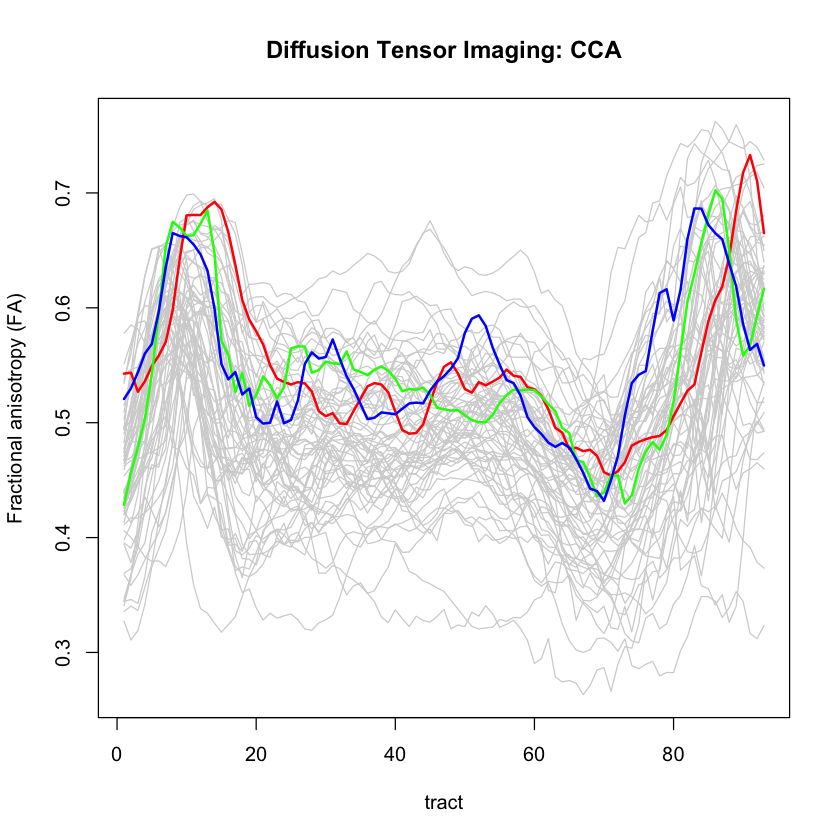

In [6]:
par(bg="white")
matplot(tract, t(DTI.baseline$cca), 
        type='l', lty=1, col="light grey",
        main = "Diffusion Tensor Imaging: CCA",
        xlab="tract", ylab="Fractional anisotropy (FA)")
sel.crv <- sample(1:n, size=3, replace=FALSE)
matlines(tract, t(DTI.baseline$cca[sel.crv,]),
        type='l', lty=1, lwd=2, col = rainbow(3))

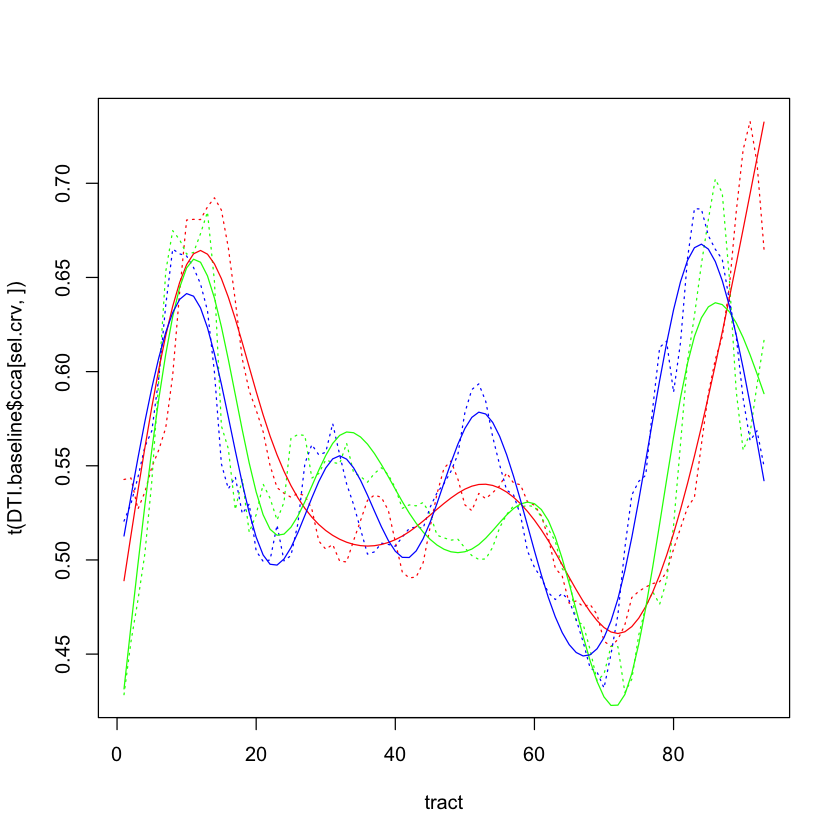

In [10]:
library(mgcv)

smooth.curves <- array(0, dim(DTI.baseline$cca))
n <- nrow(DTI.baseline$cca)
for(j in 1:n){
    fit <- gam(DTI.baseline$cca[j,] ~ s(tract, k=10, bs='cr'), mthod="REML")
    smooth.curves[j,] <- fit$fitted
}
par(bg="white")
matplot(tract, t(DTI.baseline$cca[sel.crv,]),
        type='l', lty=3, lwd=1, col=rainbow(3))
matlines(tract, t(smooth.curves[sel.crv,]),
        type='l', lty=1, lwd=1, col=rainbow(3))


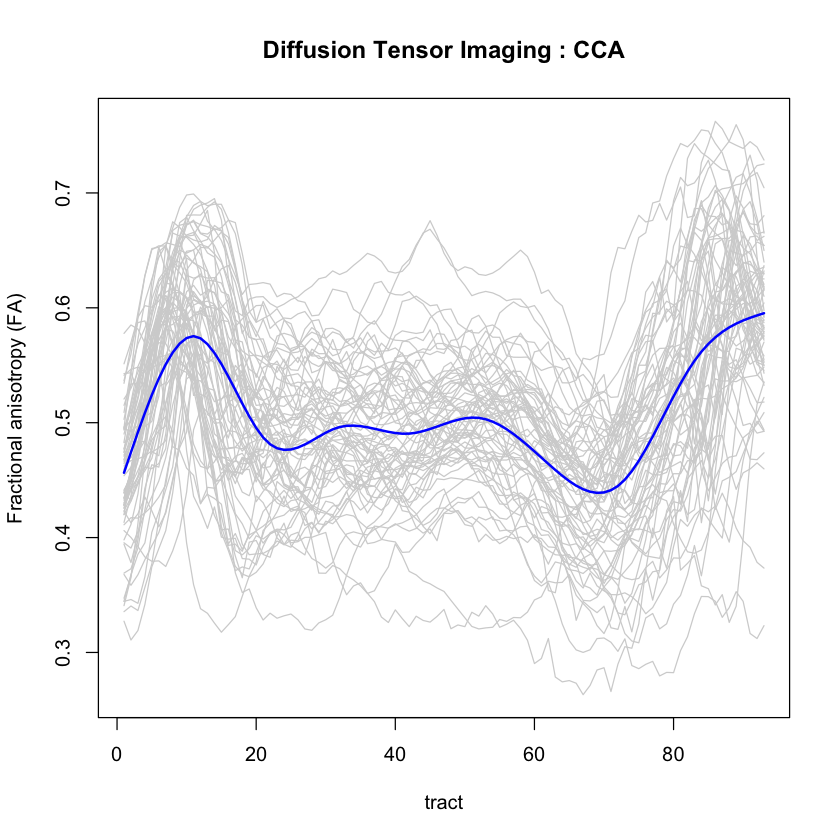

In [13]:
mean.hat <- colMeans(smooth.curves)
par(bg="white")
matplot(tract, t(DTI.baseline$cca),
        type='l', lty=1, col="light grey",
        main = "Diffusion Tensor Imaging : CCA",
        xlab="tract", ylab="Fractional anisotropy (FA)")
lines(tract, mean.hat, col='blue', lwd=2)

In [15]:
library(fields)

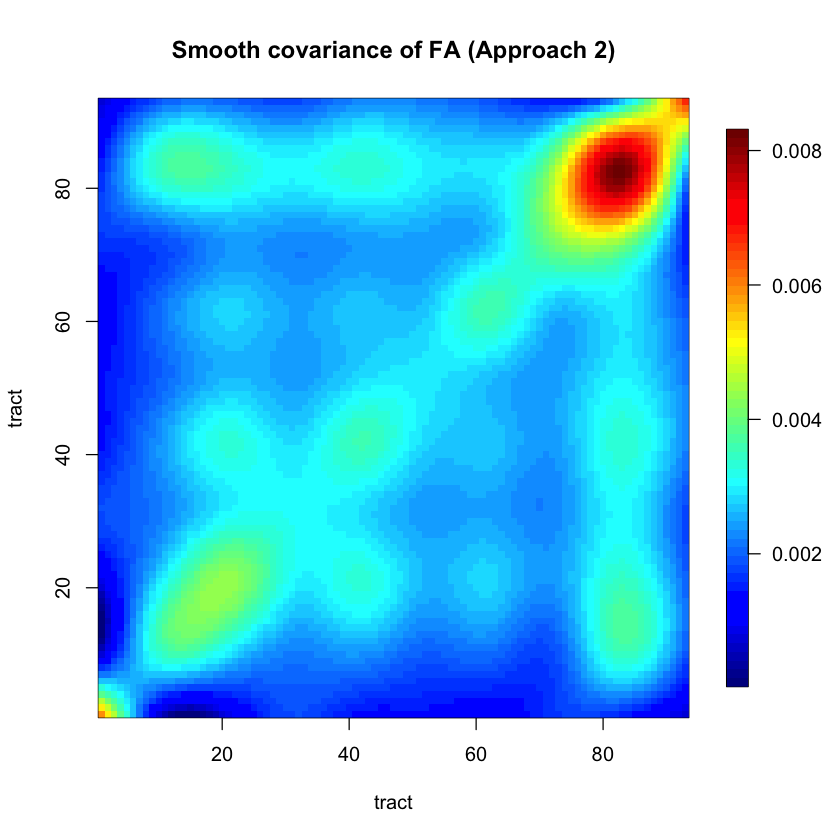

In [17]:

smooth.cov <- cov(smooth.curves)
par(bg="white")
image.plot(tract, tract, smooth.cov,
            main='Smooth covariance of FA (Approach 2)')

In [19]:
svd.result0 <- eigen(smooth.cov, symmetric=TRUE)
evectors <- svd.result0$vectors[, svd.result0$values > 0]
evalues <- svd.result0$values[svd.result0$values > 0]
head(colSums(evectors^2))

[1] 1 1 1 1 1 1

In [23]:
efns0 <- evectors*sqrt(93)
evals0 <- evalues/93
pve <- cumsum(evals0)/sum(evals0)
npc <- sum(pve < 0.95) + 1

#truncated estimated eigen components
efns <- efns0[,1:npc]
evals <- evals0[1:npc]


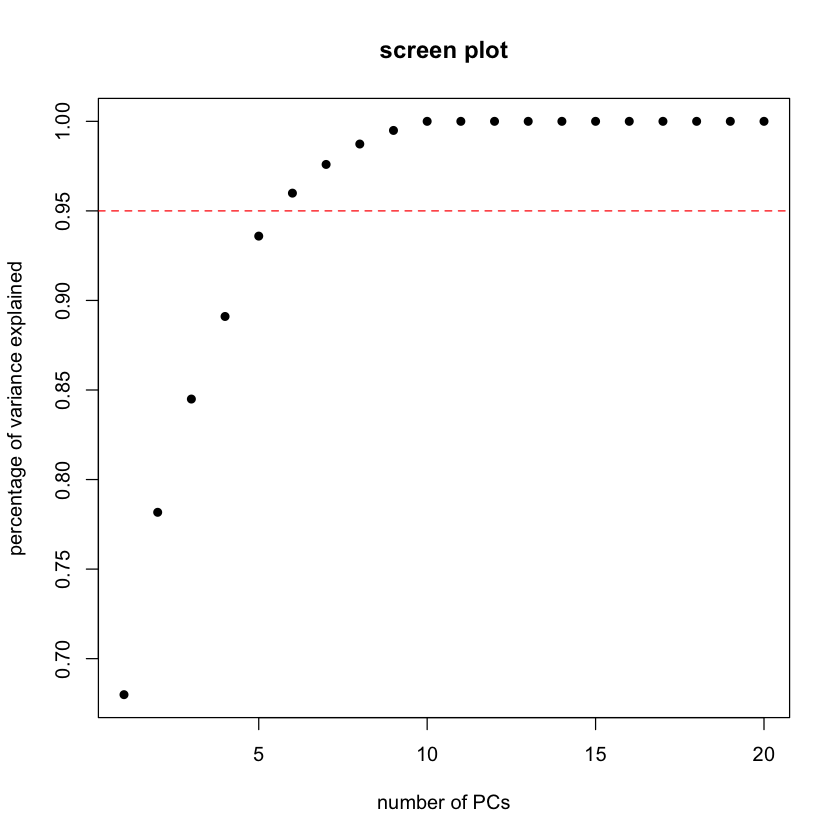

In [25]:
par(bg="white")
plot(1:20, pve[1:20], pch=16,
    ylab="percentage of variance explained", xlab="number of PCs",
    main="screen plot")

abline(h=0.95, lty=2, col='red')

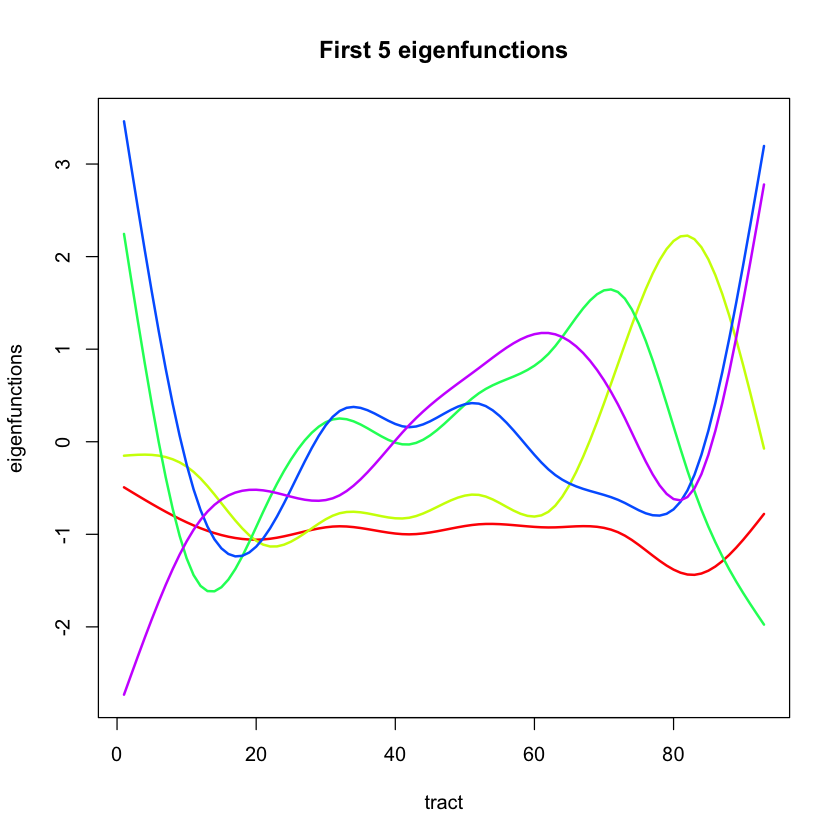

In [27]:
par(bg="white")
matplot(tract, efns[,1:5], col=rainbow(5),
        type='l', lty=1, lwd=2,
        ylab="eigenfunctions", xlab="tract",
        main="First 5 eigenfunctions")

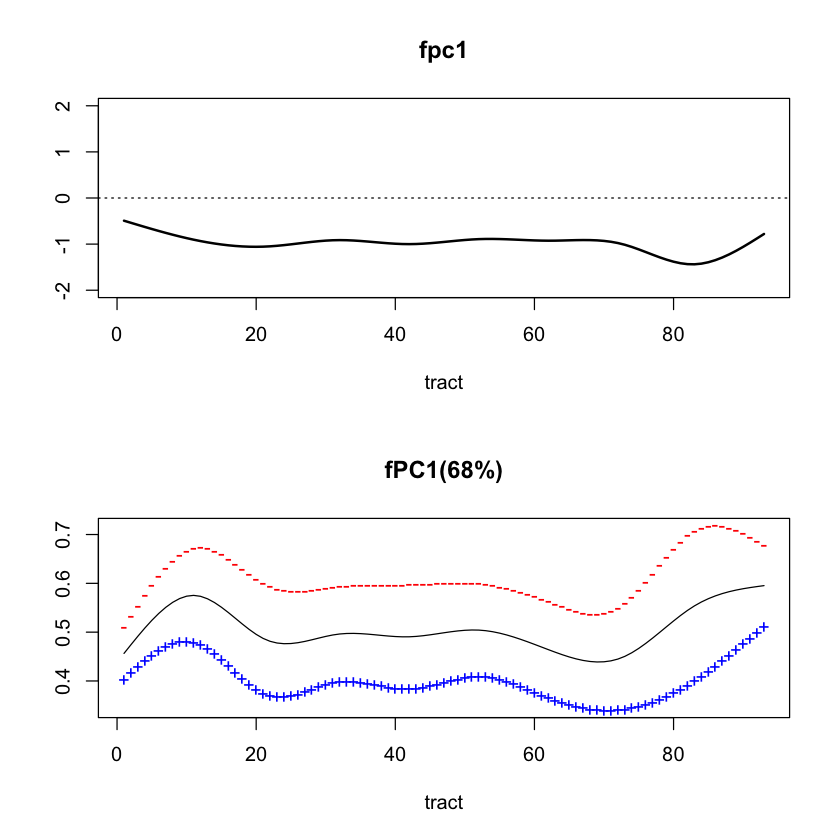

In [30]:
k.pc <- 1
effect <- efns[, k.pc]*2*sqrt(evals[k.pc])
mat <- cbind(mean.hat - effect, mean.hat + effect)

par(bg="white")
par(mfrow=c(2,1))
plot(tract, efns[,k.pc], lty=1, lwd=2, type='l', ylim=c(-2,2),
    main = paste0("fpc", k.pc), ylab="", xlab="tract" )
abline(h=0, lty=3)

matplot(tract, mat, type="p", col=c(2,4), pch=c("-", "+"),
        ylab="", xlab="tract",
        main=paste0("fPC", k.pc, "(", round(pve[k.pc]*100), "%)"))

lines(tract, mean.hat, lty=1, lwd=1)

In [ ]:
demeaned <- DTI.baseline$cca - t(matrix(rep(mean.hat, n),
                                        nrow=length))